## Import Library

In [1]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.model_selection import ParameterSampler

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV, learning_curve
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, auc, precision_recall_curve, average_precision_score
)
import joblib
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from IPython.display import display, HTML

warnings.filterwarnings('ignore', category=UserWarning)

project_path = ".."
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{project_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Colab Setup (Optional)

In [ ]:
!pip install --upgrade --force-reinstall numpy catboost pandas scipy scikit-learn matplotlib seaborn

from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/ComBio"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{project_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [2]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   race_ethnicity       3687 non-null   int64  
 3   marital_status       3687 non-null   int64  
 4   jaundice_history     3687 non-null   int64  
 5   receive_transfusion  3687 non-null   int64  
 6   liver_condition      3687 non-null   int64  
 7   injectable_drug_use  3687 non-null   int64  
 8   drug_use             3687 non-null   int64  
 9   alcohol_consumption  3687 non-null   int64  
 10  alt                  3687 non-null   float64
 11  albumin              3687 non-null   float64
 12  alp                  3687 non-null   float64
 13  ast                  3687 non-null   float64
 14  bun                  3687 non-null   float64
 15  cholesterol          3687 n

In [3]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 28)
Test shape: (489, 28)


In [4]:
numeric_features_to_scale = ['age',  'alt', 'albumin', 'alp', 'ast', 'bun', 'cholesterol', 'cpk', 'creatinine', 'ggt', 'glucose', 'total_bilirubin', 'total_calcium', 'total_protein', 'triglycerides', 'uric_acid', 'ldh', 'globulin', 'osmolality']
categorical_features = ['gender', 'race_ethnicity', 'education_level', 'marital_status', 'jaundice_history', 'receive_transfusion', 'liver_condition', 'injectable_drug_use', 'drug_use', 'alcohol_consumption']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough'
)

scaled_x_train = preprocessor.fit_transform(X_train)
scaled_x_test = preprocessor.transform(X_test)
os.makedirs(model_path, exist_ok=True)
joblib.dump(preprocessor, f"{model_path}/scaler.joblib")

['../Models/scaler.joblib']

# Training

### Evaluator Class

In [5]:
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, result_path):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.result_path = result_path
        self.models = {}
        self.results = {}
    
    def add_model(self, name, model):
        self.models[name] = model
    
    def add_models(self, models_dict):
        self.models.update(models_dict)
    
    def evaluate(self, name, show_plots=True):
        if name not in self.models:
            print(f"Model '{name}' tidak ditemukan!")
            return
        
        model = self.models[name]
        
        print(f"\n{'='*60}")
        print(f"{name}")
        print(f"{'='*60}")
        
        model.fit(self.X_train, self.y_train)
        
        y_pred = model.predict(self.X_test)
        y_pred_proba = model.predict_proba(self.X_test)[:, 1]
        
        acc = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        roc = roc_auc_score(self.y_test, y_pred_proba)
        avg_prec = average_precision_score(self.y_test, y_pred_proba)
        
        self.results[name] = {
            'model': model,
            'accuracy': acc,
            'f1_score': f1,
            'roc_auc': roc,
            'avg_precision': avg_prec,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"\nTest Results:")
        print(f"  Accuracy:          {acc:.4f}")
        print(f"  F1 Score:          {f1:.4f}")
        print(f"  ROC AUC:           {roc:.4f}")
        print(f"  Average Precision: {avg_prec:.4f}")
        
        print(f"\nClassification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['Negative', 'Positive']))
        
        if show_plots:
            self.plot_evaluation(name)
        
        os.makedirs(f"{self.result_path}/{name}", exist_ok=True)
        evaluation = {
            'accuracy': acc,
            'f1_score': f1,
            'roc_auc': roc,
            'average_precision': avg_prec
        }
        with open(f"{self.result_path}/{name}/{name}_evaluation.json", 'w') as f:
            json.dump(evaluation, f, indent=4)
    
    def plot_evaluation(self, name):
        if name not in self.results:
            print(f"Model '{name}' belum dievaluasi!")
            return
        
        y_pred = self.results[name]['y_pred']
        y_pred_proba = self.results[name]['y_pred_proba']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        axes[0].set_title(f'Confusion Matrix - {name}')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        roc_auc = self.results[name]['roc_auc']
        axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f'ROC Curve - {name}')
        axes[1].legend(loc='lower right')
        axes[1].grid(True, alpha=0.3)
        
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
        avg_prec = self.results[name]['avg_precision']
        axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_prec:.4f})')
        axes[2].set_xlim([0.0, 1.0])
        axes[2].set_ylim([0.0, 1.05])
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].set_title(f'Precision-Recall Curve - {name}')
        axes[2].legend(loc='lower left')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_all(self, show_plots=True):
        for name in self.models:
            self.evaluate(name, show_plots=show_plots)
    
    def get_summary(self):
        if not self.results:
            print("Belum ada model yang dievaluasi!")
            return
        
        summary_data = []
        for name, res in self.results.items():
            summary_data.append({
                'Model': name,
                'Accuracy': res['accuracy'],
                'F1 Score': res['f1_score'],
                'ROC AUC': res['roc_auc'],
                'Avg Precision': res['avg_precision']
            })
        
        summary_df = pd.DataFrame(summary_data)
        
        summary_df['Rank_Accuracy'] = summary_df['Accuracy'].rank(ascending=False).astype(int)
        summary_df['Rank_F1'] = summary_df['F1 Score'].rank(ascending=False).astype(int)
        summary_df['Rank_ROC_AUC'] = summary_df['ROC AUC'].rank(ascending=False).astype(int)
        summary_df['Rank_Avg_Precision'] = summary_df['Avg Precision'].rank(ascending=False).astype(int)
        
        summary_df['Avg_Rank'] = summary_df[['Rank_Accuracy', 'Rank_F1', 'Rank_ROC_AUC', 'Rank_Avg_Precision']].mean(axis=1)
        summary_df['Overall_Rank'] = summary_df['Avg_Rank'].rank().astype(int)
        
        summary_df = summary_df.sort_values('Overall_Rank')
        
        print("=" * 80)
        print("MODEL PERFORMANCE COMPARISON")
        print("=" * 80)
        
        metrics_table = summary_df[['Model', 'Accuracy', 'F1 Score', 'ROC AUC', 'Avg Precision']].copy()
        print("\nPerformance Metrics:")
        display(metrics_table.style.format({
            'Accuracy': '{:.4f}',
            'F1 Score': '{:.4f}',
            'ROC AUC': '{:.4f}',
            'Avg Precision': '{:.4f}'
        }).hide(axis='index'))
        
        print("\nModel Rankings:")
        ranking_table = summary_df[['Model', 'Rank_Accuracy', 'Rank_F1', 'Rank_ROC_AUC', 'Rank_Avg_Precision', 'Overall_Rank']].copy()
        ranking_table.columns = ['Model', 'Accuracy', 'F1 Score', 'ROC AUC', 'Avg Precision', 'Overall']
        display(ranking_table.style.hide(axis='index'))
        
        best_model = summary_df.iloc[0]['Model']
        print(f"\n{'='*80}")
        print(f"BEST MODEL: {best_model}")
        print(f"{'='*80}")
        print(f"   Accuracy:          {self.results[best_model]['accuracy']:.4f}")
        print(f"   F1 Score:          {self.results[best_model]['f1_score']:.4f}")
        print(f"   ROC AUC:           {self.results[best_model]['roc_auc']:.4f}")
        print(f"   Average Precision: {self.results[best_model]['avg_precision']:.4f}")
    
    def plot_all_curves(self):
        if not self.results:
            print("Belum ada model yang dievaluasi!")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        colors = ['blue', 'green', 'red', 'orange', 'purple']
        
        for i, (name, res) in enumerate(self.results.items()):
            fpr, tpr, _ = roc_curve(self.y_test, res['y_pred_proba'])
            axes[0].plot(fpr, tpr, color=colors[i % len(colors)], lw=2, 
                    label=f'{name} (AUC = {res["roc_auc"]:.4f})')
        
        axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve Comparison')
        axes[0].legend(loc='lower right')
        axes[0].grid(True, alpha=0.3)
        
        for i, (name, res) in enumerate(self.results.items()):
            precision, recall, _ = precision_recall_curve(self.y_test, res['y_pred_proba'])
            axes[1].plot(recall, precision, color=colors[i % len(colors)], lw=2,
                    label=f'{name} (AP = {res["avg_precision"]:.4f})')
        
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve Comparison')
        axes[1].legend(loc='lower left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_model(self, name):
        return self.results.get(name, {}).get('model', None)
    
    def get_results(self, name=None):
        if name:
            return self.results.get(name, None)
        return self.results

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, verbose=0),
    "CatBoost": CatBoostClassifier(random_state=42, silent=True, allow_writing_files=False)
}

evaluator = ModelEvaluator(scaled_x_train, scaled_x_test, y_train, y_test, result_path)
evaluator.add_models(models)

### CatBoost


CatBoost

Test Results:
  Accuracy:          0.9611
  F1 Score:          0.8939
  ROC AUC:           0.9934
  Average Precision: 0.9730

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.98       401
    Positive       0.88      0.91      0.89        88

    accuracy                           0.96       489
   macro avg       0.93      0.94      0.94       489
weighted avg       0.96      0.96      0.96       489



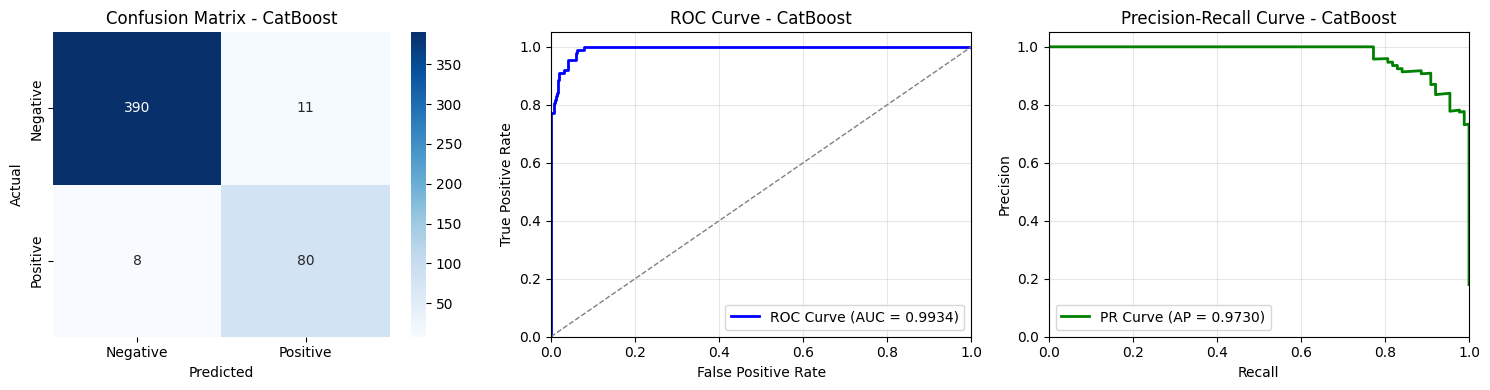

In [6]:
evaluator.evaluate("CatBoost")

### XGBoost


XGBoost

Test Results:
  Accuracy:          0.9591
  F1 Score:          0.8889
  ROC AUC:           0.9916
  Average Precision: 0.9681

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       401
    Positive       0.87      0.91      0.89        88

    accuracy                           0.96       489
   macro avg       0.92      0.94      0.93       489
weighted avg       0.96      0.96      0.96       489



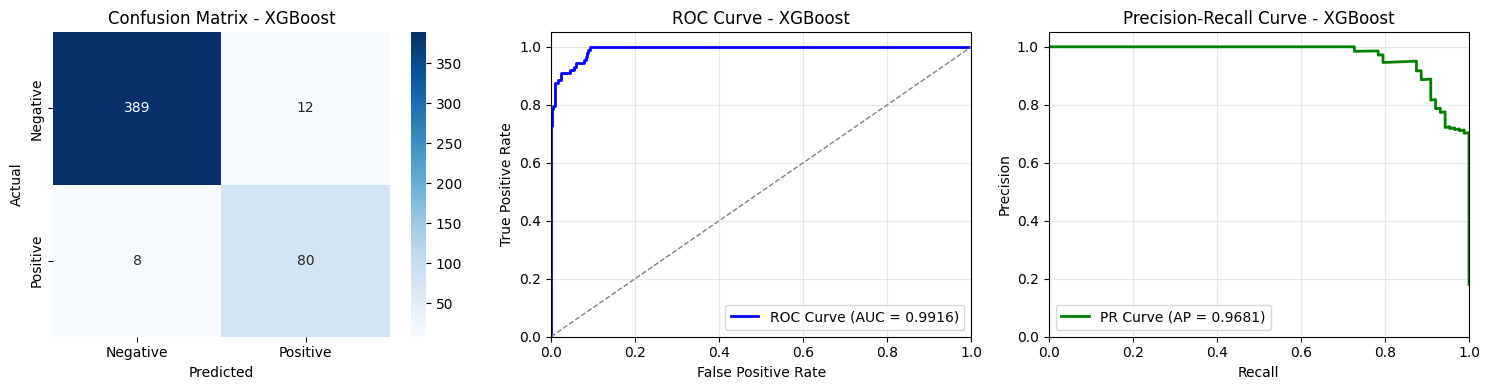

In [7]:
evaluator.evaluate("XGBoost")

### Gradient Boosting


Gradient Boosting

Test Results:
  Accuracy:          0.9550
  F1 Score:          0.8804
  ROC AUC:           0.9910
  Average Precision: 0.9626

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97       401
    Positive       0.84      0.92      0.88        88

    accuracy                           0.96       489
   macro avg       0.91      0.94      0.93       489
weighted avg       0.96      0.96      0.96       489



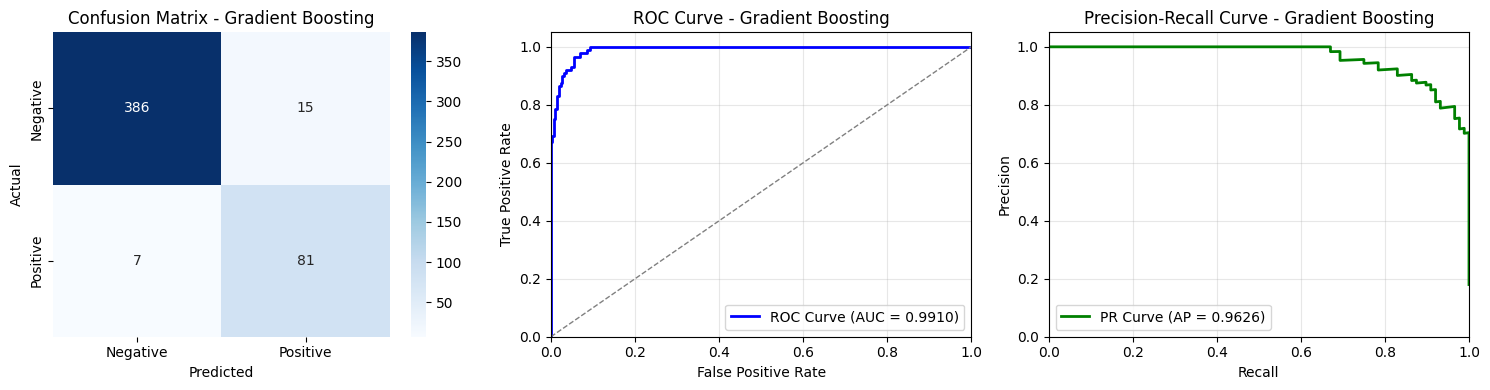

In [8]:
evaluator.evaluate("Gradient Boosting")

### Random Forest


Random Forest

Test Results:
  Accuracy:          0.9489
  F1 Score:          0.8603
  ROC AUC:           0.9865
  Average Precision: 0.9498

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       401
    Positive       0.85      0.88      0.86        88

    accuracy                           0.95       489
   macro avg       0.91      0.92      0.91       489
weighted avg       0.95      0.95      0.95       489



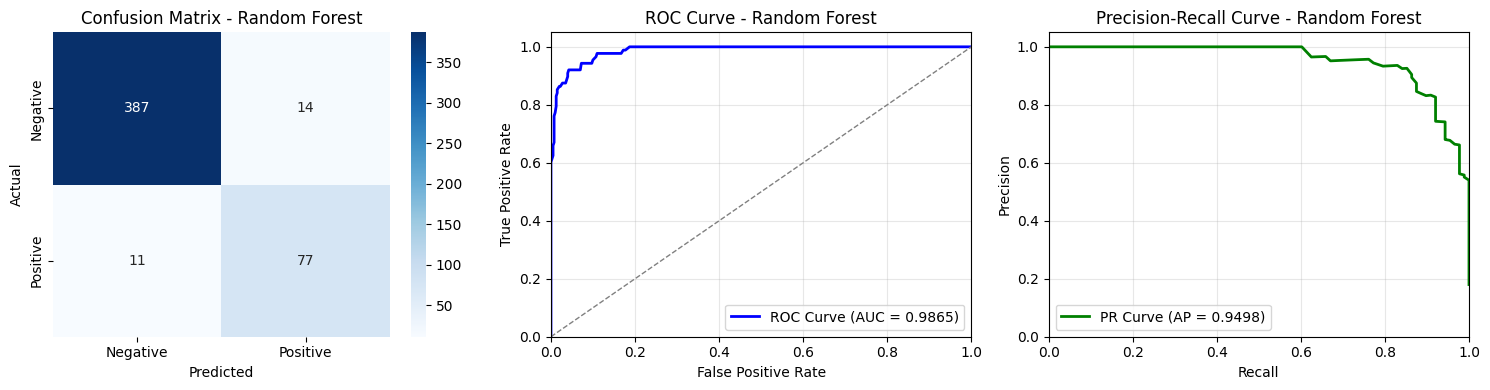

In [9]:
evaluator.evaluate("Random Forest")

### Decision Tree


Decision Tree

Test Results:
  Accuracy:          0.8814
  F1 Score:          0.7100
  ROC AUC:           0.8523
  Average Precision: 0.5462

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.90      0.93       401
    Positive       0.63      0.81      0.71        88

    accuracy                           0.88       489
   macro avg       0.79      0.85      0.82       489
weighted avg       0.90      0.88      0.89       489



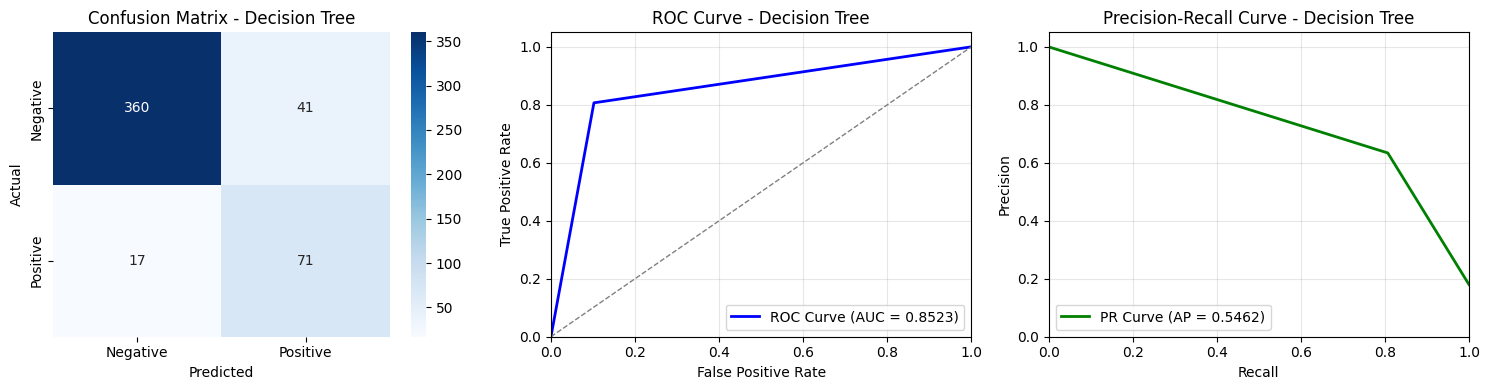

In [10]:
evaluator.evaluate("Decision Tree")

### Summary

In [11]:
evaluator.get_summary()

MODEL PERFORMANCE COMPARISON

Performance Metrics:


Model,Accuracy,F1 Score,ROC AUC,Avg Precision
CatBoost,0.9611,0.8939,0.9934,0.9730
XGBoost,0.9591,0.8889,0.9916,0.9681
Gradient Boosting,0.9550,0.8804,0.9910,0.9626
Random Forest,0.9489,0.8603,0.9865,0.9498
Decision Tree,0.8814,0.7100,0.8523,0.5462



Model Rankings:


Model,Accuracy,F1 Score,ROC AUC,Avg Precision,Overall
CatBoost,1,1,1,1,1
XGBoost,2,2,2,2,2
Gradient Boosting,3,3,3,3,3
Random Forest,4,4,4,4,4
Decision Tree,5,5,5,5,5



BEST MODEL: CatBoost
   Accuracy:          0.9611
   F1 Score:          0.8939
   ROC AUC:           0.9934
   Average Precision: 0.9730


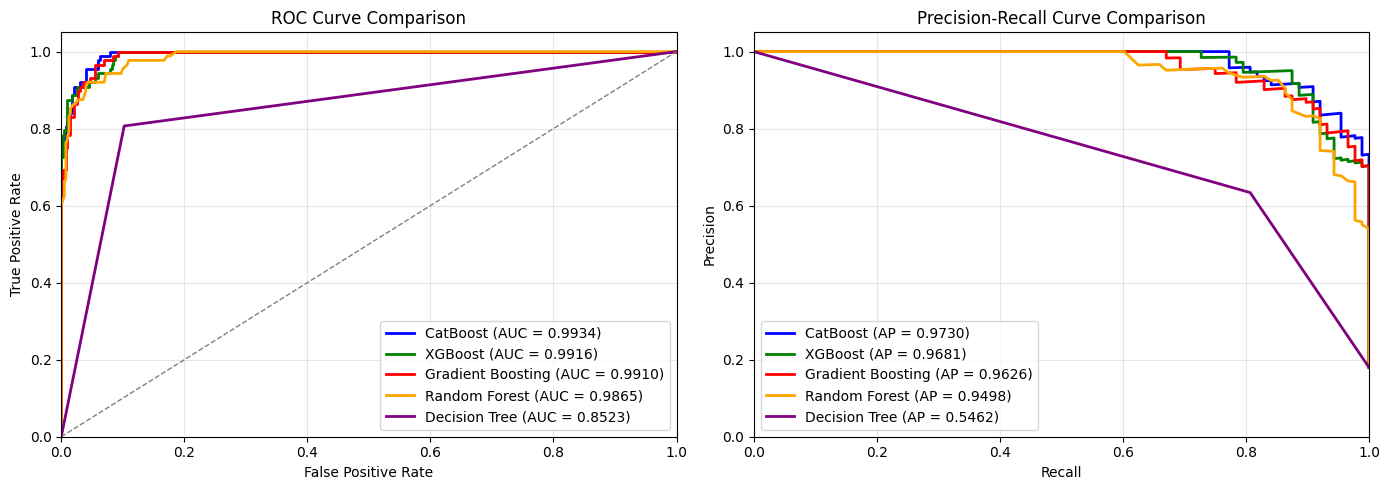

In [12]:
evaluator.plot_all_curves()